### Introduction to Breast Cancer Detection & Categorization using Deep Learning
#### This notebook present data preparation, exploratory analysis and model development for detecting and categorizing breast cancer using deep learning with ultransound images. The dataset was gotten from this repository https://scholar.cu.edu.eg/dataset_busi.zipniversity It is an image dataset in PNG format and contains 1312 records of both original images and ground truth images.

In [64]:
# Install the packages needed for the Python libraries
#pip install split-folders
#!pip install tensorflow
#!pip install keras

In [1]:
# loading necessary python libraries
import pandas as pd
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import glob
import os 
import tqdm
import splitfolders
from pathlib import Path
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import io
from skimage.color import rgb2gray
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import metrics
from tensorflow import keras
from keras import layers, optimizers
from keras.layers import Input, Flatten
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.framework.importer import import_graph_def_for_function


### Data Preparation, EDA & Pre-processing

In [4]:
# splitting of the image dataset into train, validation and test

import splitfolders
import os
import shutil
import random

Define paths for input and output directories
breastdata_in = 'C:\\Users\\TL\\FastaiBCa\\BreastCancer\\datasets'
breastdata_out = 'C:\\Users\\TL\\FastaiBCa\\BreastCancer\\sdataset'


splitfolders.ratio(breastdata_in, breastdata_out, ratio=(0.8, 0.1, 0.1), group_prefix=None)

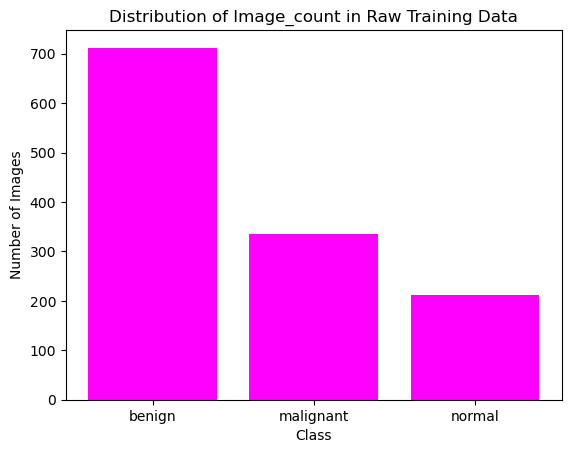

In [11]:
# Viewing the image dataset for number of record distribution
breastTrain_dir = 'C:\\Users\\TL\\FastaiBCa\\BreastCancer\\sdataset\\train_sets'
subdirs = ['benign', 'malignant', 'normal']

num_images = []
for subdir in subdirs:
    subdir_path = os.path.join(breastTrain_dir, subdir)
    num_images.append(len(glob.glob(os.path.join(subdir_path, '*.PNG'))))
    
plt.bar(subdirs, num_images, color = '#FF00FF')
plt.title('Distribution of Image_count in Raw Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

#### The two charts shows the uneven distribution in the number of images across the 3 classes which makes the data to be imbalanced

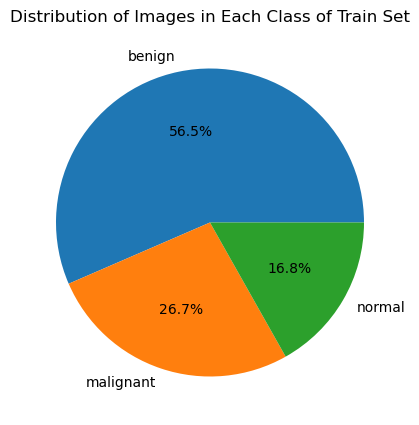

In [15]:
# Plotting of image distribution across the classes
breastTrain_dir = 'C:\\Users\\TL\\FastaiBCa\\breastcancer\\sdataset\\train_sets'
subdirs = ['benign', 'malignant', 'normal']

num_images = []
for subdir in subdirs:
    subdir_path = os.path.join(breastTrain_dir, subdir)
    num_images.append(len(glob.glob(os.path.join(subdir_path, '*.PNG'))))
    
plt.figure(figsize=(5,5))    
plt.pie(num_images, labels=subdirs, autopct='%1.1f%%')
plt.title('Distribution of Images in Each Class of Train Set')
plt.show()

Offline Data Augmentation

In [6]:
# Carrying out offline data augmentation
# This code handles two classes at a time by comparing the number of images in the two classes
# setting the batch size and image dimensions for the offline augumentation
batch_size = 32
image_size = (224, 224)

# create an ImageDataGenerator object for data augmentation
data_generator = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# set the directory containing the original images
directory = 'C:\\Users\\TL\\FastaiBCa\\breastcancer\\sdatasets\\train_sets\\'

# set the directory to save the augmented images
augsave_dir = 'C:\\Users\\TL\\FastaiBCa\\breastcancer\\sdataset_aug\\'

# create the directory if it doesn't already exist
if not os.path.exists(augsave_dir):
    os.makedirs(augsave_dir)

# counting the number of images in each class or sub directory
num_images_per_class = {}
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    num_images_per_class[subdir] = len(os.listdir(subdir_path))

# determine the maximum number of images per class
max_images_per_class = max(num_images_per_class.values())

# loop through each class directory and generate augmented images
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    num_images = len(os.listdir(subdir_path))
    if num_images < max_images_per_class:
        # create a generator for the original images in this class
        image_generator = data_generator.flow_from_directory(
            directory=directory,
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical',
            classes=[subdir])
        # generate augmented images and save them to disk
        num_augmentations = max_images_per_class - num_images
        for i in range(num_augmentations // batch_size):
            images, _ = next(image_generator)
            for j in range(len(images)):
                image = Image.fromarray(images[j].astype('uint8'))
                save_filename = os.path.join(save_dir, subdir + '_' + str(i*batch_size + j) + '.PNG')
                image.save(save_filename, format='PNG')
      

Found 336 images belonging to 1 classes.
Added 336 images to class malignant
Found 212 images belonging to 1 classes.
Added 456 images to class normal


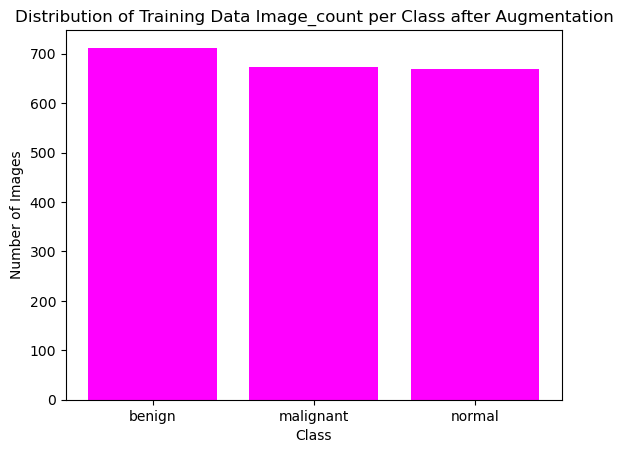

In [12]:
# Plotting of augmented dataset
breastTrain_dir = 'C:\\Users\\TL\\FastaiBCa\\breastcancer\\sdataset_aug\\train_sets'
subdirs = ['benign', 'malignant', 'normal']

num_images = []
for subdir in subdirs:
    subdir_path = os.path.join(breastTrain_dir, subdir)
    num_images.append(len(glob.glob(os.path.join(subdir_path, '*.PNG'))))
#print('Class'{}: {} images',format(subdir, num_images))
    
plt.bar(subdirs, num_images, color = '#FF00FF')
plt.title('Distribution of Training Data Image_count per Class after Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

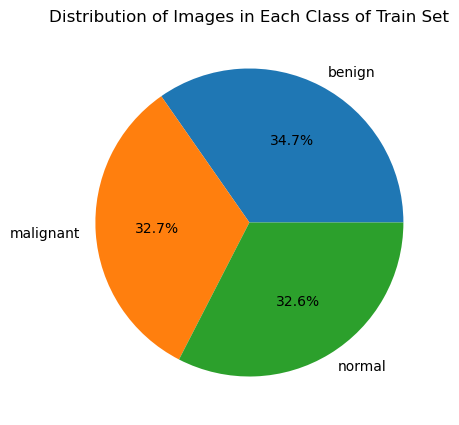

In [16]:
breastTrain_dir = 'C:\\Users\\TL\\FastaiBCa\\breastcancer\\sdataset_aug\\train_sets'
subdirs = ['benign', 'malignant', 'normal']

num_images = []
for subdir in subdirs:
    subdir_path = os.path.join(breastTrain_dir, subdir)
    num_images.append(len(glob.glob(os.path.join(subdir_path, '*.PNG'))))
plt.figure(figsize=(5,5))     
plt.pie(num_images, labels=subdirs, autopct='%1.1f%%')
plt.title('Distribution of Images in Each Class of Train Set')
#plt.xlabel('Class')
#plt.ylabel('Number of Images')
plt.show()

#### The chart shows image distribution after the augmentation process across the 3 classes which is almost the same. This will improve the accuracy of the model

In [95]:
# Re-defining data directories and parameters / data dimension
breastTrain_dir = 'sdataset/train_sets'
breastTest_dir = 'sdataset/test_sets'
breastVal_dir = 'sdataset/val_sets'
batch_size = 32
img_height = 224
img_width = 224

In [22]:
# Creating image generator object for data augmentation purpose and normalizing so as to improve the model performance
trainset_generator = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')  

In [23]:
# Creating image generator and normalizing image data for validation and test sets
validset_generator = ImageDataGenerator(rescale = 1./255)
                               

testset_generator = ImageDataGenerator(rescale = 1./255)

In [24]:
# Loading the train sets
train_set = trainset_generator.flow_from_directory(
    breastTrain_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 2052 images belonging to 3 classes.


In [28]:
# Getting the class indices for the training set
class_indices = train_set.class_indices
print(class_indices)

{'benign': 0, 'malignant': 1, 'normal': 2}


In [25]:
# Loading the Validation sets
valid_set = validset_generator.flow_from_directory(
    breastVal_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 157 images belonging to 3 classes.


In [96]:
# Loading the test sets
test_set = testset_generator.flow_from_directory(
    breastTest_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 84 images belonging to 3 classes.


In [ ]:
# Total image is 2370

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 400.11it/s]


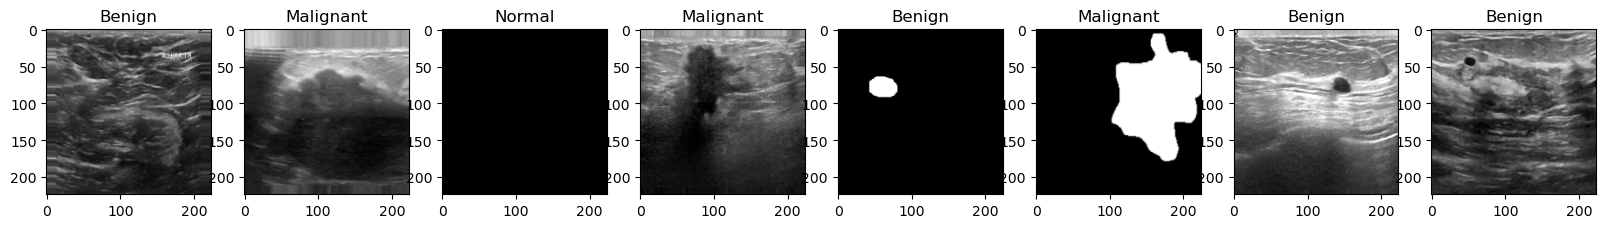

In [27]:
# Displaying of train dataset images
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(20, 20))
batch = next(train_set)
for i in tqdm(range(0, 8)):
    rand1 = np.random.randint(batch[0].shape[0])
    ax[i].imshow(batch[0][rand1])
    # ax[i].axis('off')
    a = batch[1][rand1]
    if a[0] == 1:
        ax[i].set_title('Benign')
    elif a[1] == 1:
        ax[i].set_title('Malignant')
    elif a[2] == 1:
        ax[i].set_title('Normal')


# Model Development

In [29]:
%%time
#First Base Model- Convolution neural network
model_cnn = Sequential([
    layers.Conv2D(32, 4, padding = 'same', activation = 'relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 4, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 4, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation = 'softmax')
])


#Compile the model with optimizer and metrics
model_cnn.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              metrics=[metrics.AUC(name='auc')])



CPU times: total: 469 ms
Wall time: 387 ms


In [30]:
%%time
#model = get_model()
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        32832     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [31]:
# Defining Callbacks

filepath = './cnn_bestmodel.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', mode = 'max', patience = 15, verbose = 1)
                          
checkpoint = ModelCheckpoint(filepath, monitor = 'val_auc', mode='max', save_best_only=True, verbose = 1)

callback_list = [earlystopping, checkpoint]

In [32]:
%%time
# fit the model
history = model_cnn.fit(train_set, validation_data=valid_set,
                    epochs= 100,
                    callbacks=callback_list,
                    verbose=1)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 1.1844 - auc: 0.6764
Epoch 00001: val_auc improved from -inf to 0.51930, saving model to .\cnn_bestmodel.hdf5
65/65 [==============================] - 173s 3s/step - loss: 1.1844 - auc: 0.6764 - val_loss: 1.0940 - val_auc: 0.5193
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.8724 - auc: 0.7588
Epoch 00002: val_auc improved from 0.51930 to 0.74930, saving model to .\cnn_bestmodel.hdf5
65/65 [==============================] - 160s 2s/step - loss: 0.8724 - auc: 0.7588 - val_loss: 1.0455 - val_auc: 0.7493
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.8307 - auc: 0.7896
Epoch 00003: val_auc improved from 0.74930 to 0.77396, saving model to .\cnn_bestmodel.hdf5
65/65 [==============================] - 162s 2s/step - loss: 0.8307 - auc: 0.7896 - val_loss: 1.0570 - val_auc: 0.7740
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 0.8013 - auc: 0.7940
Epoch 0

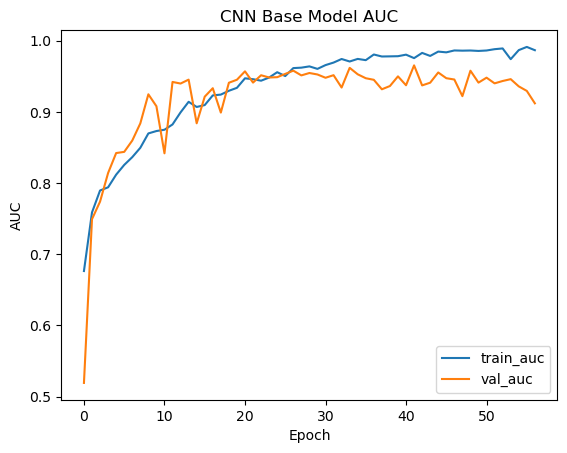

Final AUC (training set): 0.9866
Final AUC (validation set): 0.9120


In [33]:
# The model history is stored in a variable named 'history'
# and contains the metrics 'auc' and 'val_auc'

# Plot the training and validation AUC over epochs
plt.plot(history.history['auc'], label='train_auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.title('CNN Base Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Print the final AUC values for the training and validation sets
train_auc = history.history['auc'][-1]
val_auc = history.history['val_auc'][-1]
print('Final AUC (training set): {:.4f}'.format(train_auc))
print('Final AUC (validation set): {:.4f}'.format(val_auc))

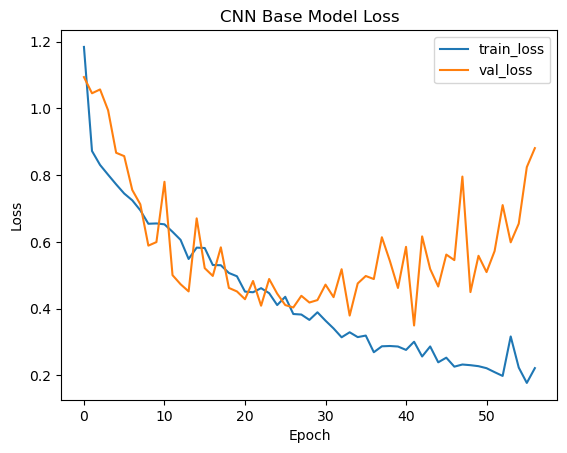

In [34]:
# Plot the training and validation loss function over epochs
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('CNN Base Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Model Performance Evaluation
model_cnn.evaluate(test_set)

### Pre-Trained Models

In [41]:
%%time
## Creating the base model(in this case, we will use DenseNet169)

baseModel = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

CPU times: total: 4.94 s
Wall time: 5.5 s


In [42]:
# Freeze the pre-trained layers
# freezing the pre-trained layers prevent their weights from being updated during training, 
# which helps to preserve the general features learned by the model. 
for layer in baseModel.layers:
    layer.trainable=False

In [43]:
%%time
# Building Model and adjustment of the needed parameters
for layer in baseModel.layers:
    layer.trainable=False
model_des=Sequential()
model_des.add(baseModel)
model_des.add(Dropout(0.5))
model_des.add(Flatten())
model_des.add(BatchNormalization())
model_des.add(Dense(2048,kernel_initializer='he_uniform'))
model_des.add(BatchNormalization())
model_des.add(Activation('relu'))
model_des.add(Dropout(0.5))
model_des.add(Dense(1024,kernel_initializer='he_uniform'))
model_des.add(BatchNormalization())
model_des.add(Activation('relu'))
model_des.add(Dropout(0.5))
model_des.add(Dense(3,activation='softmax'))

CPU times: total: 22.8 s
Wall time: 13.1 s


In [44]:
# Summmary of the Model Architecture
model_des.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 1664)        0         
                                                                 
 flatten_1 (Flatten)         (None, 81536)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 81536)            326144    
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 2048)              166987776 
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                      

In [47]:
%%time
# Compiling the Model
# import the python library first
from tensorflow.keras import metrics, optimizers
opt = optimizers.Adam(learning_rate=0.001)
model_des.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=[metrics.AUC(name='auc')])
  

CPU times: total: 31.2 ms
Wall time: 42 ms


In [46]:
# Defining Callbacks

filepath = './desnet_bestmodel.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', mode = 'max', patience = 15, verbose = 1)
                          
checkpoint = ModelCheckpoint(filepath, monitor = 'val_auc', mode='max', save_best_only=True, verbose = 1)

callback_list = [earlystopping, checkpoint]

In [51]:
%%time
# Fitting the model 
history = model_des.fit(train_set, validation_data=valid_set,
                    epochs = 100,
                    callbacks=callback_list,
                    verbose=1)

Epoch 1/100
65/65 [==============================] - ETA: 0s - loss: 0.6075 - auc: 0.9262
Epoch 00001: val_auc improved from -inf to 0.91442, saving model to .\desnet_bestmodel.hdf5
65/65 [==============================] - 544s 8s/step - loss: 0.6075 - auc: 0.9262 - val_loss: 1.2212 - val_auc: 0.9144
Epoch 2/100
65/65 [==============================] - ETA: 0s - loss: 0.3838 - auc: 0.9650
Epoch 00002: val_auc improved from 0.91442 to 0.94732, saving model to .\desnet_bestmodel.hdf5
65/65 [==============================] - 475s 7s/step - loss: 0.3838 - auc: 0.9650 - val_loss: 0.5541 - val_auc: 0.9473
Epoch 3/100
65/65 [==============================] - ETA: 0s - loss: 0.3221 - auc: 0.9737
Epoch 00003: val_auc improved from 0.94732 to 0.97482, saving model to .\desnet_bestmodel.hdf5
65/65 [==============================] - 470s 7s/step - loss: 0.3221 - auc: 0.9737 - val_loss: 0.3113 - val_auc: 0.9748
Epoch 4/100
65/65 [==============================] - ETA: 0s - loss: 0.2727 - auc: 0.979

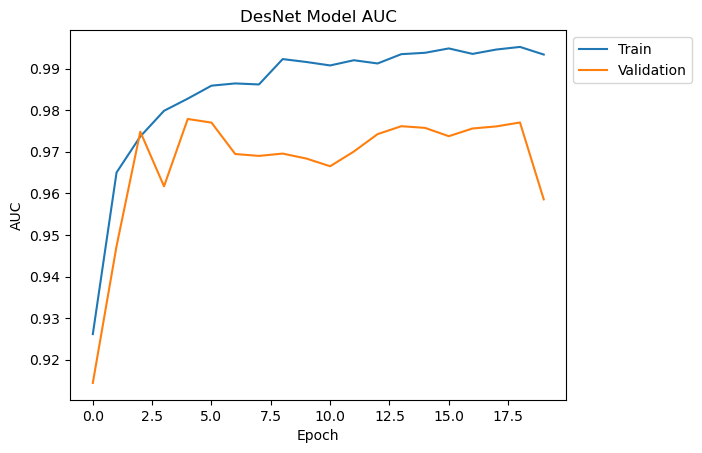

Final AUC (training set): 0.9934
Final AUC (validation set): 0.9585


In [52]:
 # History for loss and Value accuracy summary

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('DesNet Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Print the final AUC values for the training and validation sets
train_auc = history.history['auc'][-1]
val_auc = history.history['val_auc'][-1]
print('Final AUC (training set): {:.4f}'.format(train_auc))
print('Final AUC (validation set): {:.4f}'.format(val_auc))

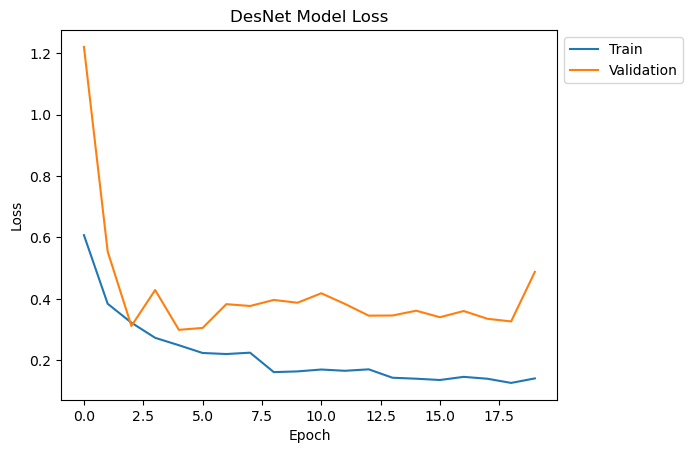

In [53]:
# Summary of the history for loss function

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DesNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

##### ResNet50 Model

In [66]:
%%time
## Instantiate the ResNet50 model

restnet = ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
output = restnet.layers[-1].output
output = layers.Flatten()(output)

restnet = Model(restnet.input, output)

for layer in restnet.layers:
    layer.trainable = False

model_res = Sequential([
    restnet,
    layers.Dense(3, activation="softmax")
])

CPU times: total: 3.55 s
Wall time: 2.91 s


In [71]:
from tensorflow.keras import metrics, optimizers
opt = optimizers.Adam(learning_rate=0.001)
model_res.compile(loss = 'categorical_crossentropy',
optimizer=opt, metrics=[metrics.AUC(name='auc')])


In [72]:
model_res.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 100352)            23587712  
                                                                 
 dense_8 (Dense)             (None, 3)                 301059    
                                                                 
Total params: 23,888,771
Trainable params: 301,059
Non-trainable params: 23,587,712
_________________________________________________________________


In [73]:
# Defining Callbacks

filepath = './res_bestmodel.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', mode = 'max', patience = 15, verbose = 1)
                          
checkpoint = ModelCheckpoint(filepath, monitor = 'val_auc', mode='max', save_best_only=True, verbose = 1)

callback_list = [earlystopping, checkpoint]


In [74]:
%%time
# Fitting the model 
history = model_res.fit(train_set, validation_data=valid_set,
                    epochs = 50,
                    callbacks=callback_list,
                    verbose=1)

Epoch 1/50
65/65 [==============================] - ETA: 0s - loss: 1.0550 - auc: 0.6344
Epoch 00001: val_auc improved from -inf to 0.69370, saving model to .\res_bestmodel.hdf5


C:\Users\TL\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


65/65 [==============================] - 297s 5s/step - loss: 1.0550 - auc: 0.6344 - val_loss: 0.9399 - val_auc: 0.6937
Epoch 2/50
65/65 [==============================] - ETA: 0s - loss: 0.9413 - auc: 0.7217
Epoch 00002: val_auc improved from 0.69370 to 0.79475, saving model to .\res_bestmodel.hdf5
65/65 [==============================] - 302s 5s/step - loss: 0.9413 - auc: 0.7217 - val_loss: 0.8372 - val_auc: 0.7947
Epoch 3/50
65/65 [==============================] - ETA: 0s - loss: 0.9428 - auc: 0.7234
Epoch 00003: val_auc improved from 0.79475 to 0.82713, saving model to .\res_bestmodel.hdf5
65/65 [==============================] - 302s 5s/step - loss: 0.9428 - auc: 0.7234 - val_loss: 0.8087 - val_auc: 0.8271
Epoch 4/50
65/65 [==============================] - ETA: 0s - loss: 0.8817 - auc: 0.7691
Epoch 00004: val_auc improved from 0.82713 to 0.85497, saving model to .\res_bestmodel.hdf5
65/65 [==============================] - 300s 5s/step - loss: 0.8817 - auc: 0.7691 - val_loss: 0.

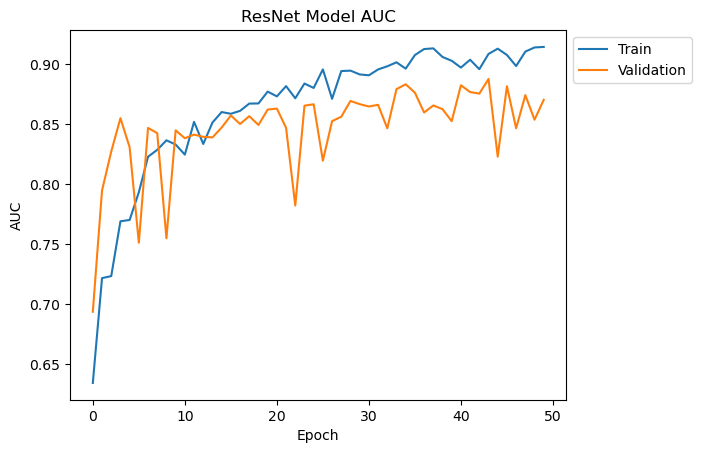

Final AUC (training set): 0.9143
Final AUC (validation set): 0.8703


In [75]:
 # History for loss and Value accuracy summary

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('ResNet Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

# Print the final AUC values for the training and validation sets
train_auc = history.history['auc'][-1]
val_auc = history.history['val_auc'][-1]
print('Final AUC (training set): {:.4f}'.format(train_auc))
print('Final AUC (validation set): {:.4f}'.format(val_auc))

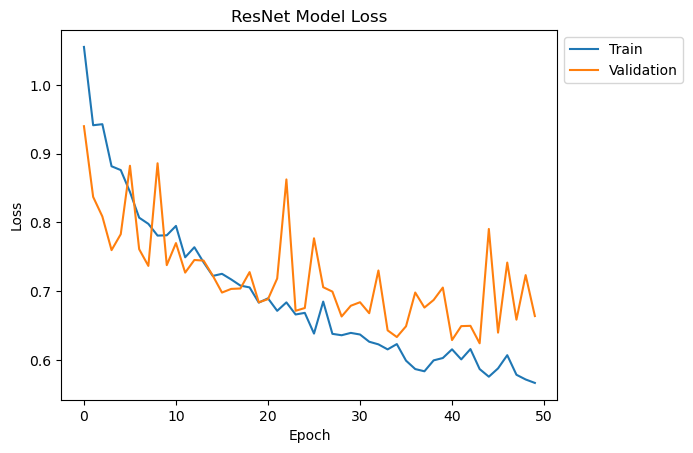

In [76]:
# Summary of the history for loss function

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

##### AlexNet model

In [79]:
model_ale = Sequential()

# Layer 1: Convolutional layer with 96 filters, 11x11 kernel size, and ReLU activation
model_ale.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), input_shape=(224,224,3), activation='relu'))

# Layer 2: Max pooling layer with 3x3 pool size and stride 2
model_ale.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Layer 3: Convolutional layer with 256 filters, 5x5 kernel size, and ReLU activation
model_ale.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'))

# Layer 4: Max pooling layer with 3x3 pool size and stride 2
model_ale.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Layer 5: Convolutional layer with 384 filters, 3x3 kernel size, and ReLU activation
model_ale.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

# Layer 6: Convolutional layer with 384 filters, 3x3 kernel size, and ReLU activation
model_ale.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

# Layer 7: Convolutional layer with 256 filters, 3x3 kernel size, and ReLU activation
model_ale.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))

# Layer 8: Max pooling layer with 3x3 pool size and stride 2
model_ale.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# Layer 9: Flatten layer
model_ale.add(Flatten())

# Layer 10: Fully connected layer with 4096 units and ReLU activation
model_ale.add(Dense(units=4096, activation='relu'))

# Layer 11: Dropout layer with a rate of 0.5
model_ale.add(Dropout(rate=0.5))

# Layer 12: Fully connected layer with 4096 units and ReLU activation
model_ale.add(Dense(units=4096, activation='relu'))

# Layer 13: Dropout layer with a rate of 0.5
model_ale.add(Dropout(rate=0.5))

# Layer 14: Fully connected layer with 1000 units and softmax activation
model_ale.add(Dense(units=3, activation='softmax'))

# compile
model_ale.compile(loss = 'categorical_crossentropy',
optimizer='adam',
metrics=[metrics.AUC(name='auc')])

In [80]:
model_ale.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 384)       885120    
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 384)      

In [81]:
%%time
# Fitting the model 
history = model_ale.fit(train_set, validation_data=valid_set,
                    epochs = 50,
                    callbacks=callback_list,
                    verbose=1)

Epoch 1/50
65/65 [==============================] - ETA: 0s - loss: 0.9934 - auc: 0.7429
Epoch 00001: val_auc did not improve from 0.88765
65/65 [==============================] - 197s 3s/step - loss: 0.9934 - auc: 0.7429 - val_loss: 0.7136 - val_auc: 0.8408
Epoch 2/50
65/65 [==============================] - ETA: 0s - loss: 0.7643 - auc: 0.8090
Epoch 00002: val_auc did not improve from 0.88765
65/65 [==============================] - 198s 3s/step - loss: 0.7643 - auc: 0.8090 - val_loss: 0.7564 - val_auc: 0.8152
Epoch 3/50
65/65 [==============================] - ETA: 0s - loss: 0.7258 - auc: 0.8294
Epoch 00003: val_auc did not improve from 0.88765
65/65 [==============================] - 196s 3s/step - loss: 0.7258 - auc: 0.8294 - val_loss: 0.6866 - val_auc: 0.8487
Epoch 4/50
65/65 [==============================] - ETA: 0s - loss: 0.6920 - auc: 0.8485
Epoch 00004: val_auc did not improve from 0.88765
65/65 [==============================] - 197s 3s/step - loss: 0.6920 - auc: 0.8485 -

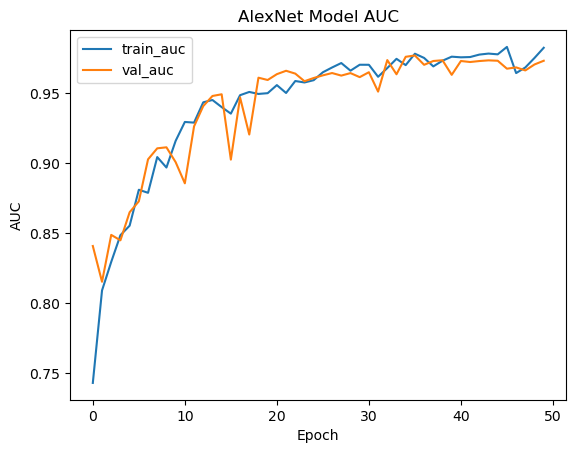

Final AUC (training set): 0.9825
Final AUC (validation set): 0.9732


In [100]:
# History for loss and Value accuracy summary

# Plot the training and validation AUC over epochs
plt.plot(history.history['auc'], label='train_auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.title('AlexNet Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Print the final AUC values for the training and validation sets
train_auc = history.history['auc'][-1]
val_auc = history.history['val_auc'][-1]
print('Final AUC (training set): {:.4f}'.format(train_auc))
print('Final AUC (validation set): {:.4f}'.format(val_auc))

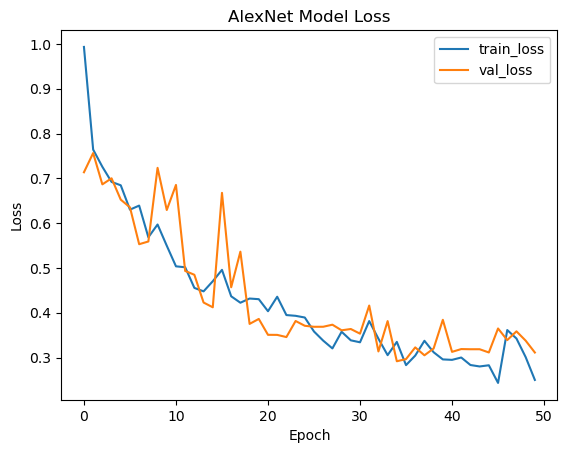

In [101]:
# Summary of the history for loss function

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('AlexNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Model's Perfomance  Evaluation

In [35]:
%%time
# Evaluating CNN base model
model_cnn.evaluate(test_set)

# Evaluating the model
train_loss, train_acc = model_cnn.evaluate(train_set, steps=32)
test_loss, test_acc = model_cnn.evaluate(test_set, steps=32)
print('Train: %.4f, Test: %.4f' %(train_acc,test_acc)) 

32/32 [==============================] - 6s 173ms/step - loss: 0.8960 - auc: 0.9036
Train: 0.9708, Test: 0.9036
CPU times: total: 1min 36s
Wall time: 42.8 s


In [54]:
%%time
# Evaluating DesNet169 model
model_des.evaluate(test_set)

# Evaluating the model
train_loss, train_acc = model_des.evaluate(train_set, steps=32)
test_loss, test_acc = model_des.evaluate(test_set, steps=32)
print('Train: %.4f, Test: %.4f' %(train_acc,test_acc)) 

32/32 [==============================] - 25s 641ms/step - loss: 0.3459 - auc: 0.9737
Train: 0.9958, Test: 0.9737
CPU times: total: 11min 59s
Wall time: 4min 1s


In [77]:
%%time
# Evaluating ResNet50 model
model_res.evaluate(test_set)

# Evaluating the model
train_loss, train_acc = model_res.evaluate(train_set, steps=32)
test_loss, test_acc = model_res.evaluate(test_set, steps=32)
print('Train: %.4f, Test: %.4f' %(train_acc,test_acc)) 

32/32 [==============================] - 22s 582ms/step - loss: 0.6825 - auc: 0.8705
Train: 0.9217, Test: 0.8705
CPU times: total: 9min 14s
Wall time: 2min 54s


In [97]:
%%time
# Evaluating AlexNet model
model_ale.evaluate(test_set)

# Evaluating the model
train_loss, train_acc = model_ale.evaluate(train_set, steps=32)
test_loss, test_acc = model_ale.evaluate(test_set, steps=32)
print('Train: %.4f, Test: %.4f' %(train_acc,test_acc)) 

32/32 [==============================] - 3s 46ms/step - loss: 0.5045 - auc: 0.9302
Train: 0.9896, Test: 0.9302
CPU times: total: 1min 46s
Wall time: 46.3 s


##### Model's Prediction using Test Image Data

93.53 % chances are there that the image is benign


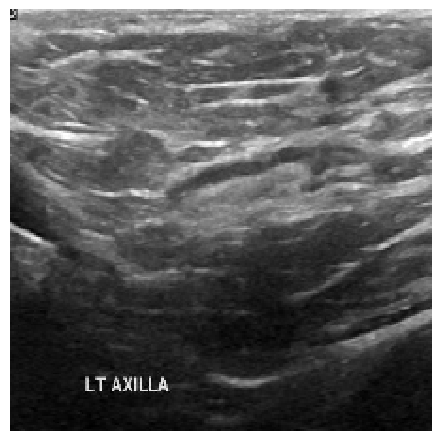

In [90]:
# Prediction using the best model
# Prediction case for Benign
dic_test = test_set.class_indices
ikc = {k:v for v, k in dic_test.items()}

test_img = load_img('C:/Users/TL/FastaiBCa/breastcancer/sdataset/test_sets/benign/benign (292).PNG', target_size = (224,224,3))                                                                                                                                                  
test_img = img_to_array(test_img)
test_img = test_img/255
imshow(test_img)
plt.axis('off')
test_img = np.expand_dims(test_img,axis=0)
prediction = (model_des.predict(test_img) > 0.5).astype("int32")

probability = round(np.max(model_des.predict(test_img)*100),2)

print(probability, '% chances are there that the image is benign')

91.13 % chances are there that the image is malignant


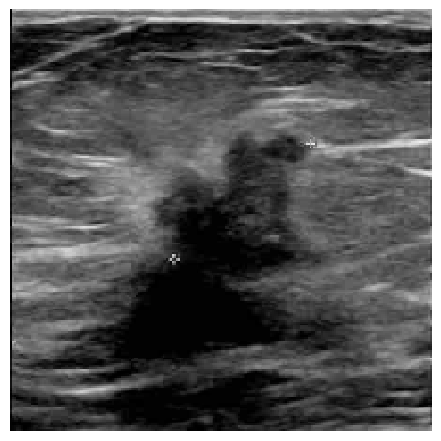

In [91]:
# Prediction using the best model
# Prediction case for Benign
dic_test = test_set.class_indices
ikc = {k:v for v, k in dic_test.items()}

test_img = load_img('C:/Users/TL/Teesside Tutorial/BreastCancer/datasets/malignant/img3.PNG', target_size = (224,224,3))                                                                                                                               
test_img = img_to_array(test_img)
test_img = test_img/255
imshow(test_img)
plt.axis('off')
test_img = np.expand_dims(test_img,axis=0)
prediction = (model_des.predict(test_img) > 0.5).astype("int32")

probability = round(np.max(model_des.predict(test_img)*100),2)

print(probability, '% chances are there that the image is malignant')